# The Goal of This Notebook
---
## Training LSTM model for credit scoring with time series data.

## Importing Libraries


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd, pyarrow
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import re
import os, glob, math
import joblib
import torch
import os, numpy as np, matplotlib.pyplot as plt, mlflow
import mlflow
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader,  WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, accuracy_score, f1_score, average_precision_score, recall_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import tempfile, shutil
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler

import torch

from tqdm import tqdm 
from numpy.lib.stride_tricks import sliding_window_view
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
from mlflow.tracking import MlflowClient

# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import config
from src.logger import logger
from src.database import clickhouse_engine, postgres_engine, ipdr_engine    
from src.visualization import *

Configuration loaded successfully.


2025-11-06 10:16:58,981 | my_logger - INFO - ✅ PostgreSQL engine создан | /data/aturov/scoring/src/database.py:21
2025-11-06 10:16:59,009 | my_logger - INFO - ✅ ClickHouse engine создан | /data/aturov/scoring/src/database.py:36
2025-11-06 10:16:59,010 | my_logger - INFO - ✅ IPDR ClickHouse engine создан | /data/aturov/scoring/src/database.py:46


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logger.info(f"Using device: {device}")

2025-11-06 10:16:59,584 | my_logger - INFO - Using device: cuda | /tmp/ipykernel_295432/1906506296.py:7


## Constants and Settings

In [3]:
DATE_FEATURES = '2025-11-04'  # дата формирования датасета
SPLINT_DATE = '2024-12-01'  # дата сплита на трейн и валидацию
DATE_END = "2025-03-30"         # cap for date_open (filtering); set as needed
TARGET_COL = 'target'  # целевая переменная
DROP_FEATURES = ['CELL_ID', 'CELL_MAX', 'DEV_NAME', 'TAC']  # признаки для удаления перед обучением модели
# DROP_FEATURES = []
COUNT_WEEKS = 12  # ожидаем 1..12, где 1 ближе всего к дате выдачи (должен быть последним тайм-степом)
OVERDUE_DAYS_MAX = 30           # example threshold for 'bad' target
TOTAL_OVERDUE = 90               # example threshold for total overdue days/amount
SEQ_COL = 'count_weeks'  # имя колонки с количеством недель в последовательности
BATCH_SIZE = 64 # Размер батча

CURRENT_DATE = datetime.now().strftime('%Y-%m-%d')

CALIBRATION_METHOD = 'sigmoid'  # использовать ли калибровку вероятностей
NAME_DATAFRAME = 'features_weeks'  # имя файла с табличными признаками
NAME_DATAFRAME_WEEKS = f'{NAME_DATAFRAME}_{COUNT_WEEKS}_{OVERDUE_DAYS_MAX}_{TOTAL_OVERDUE}' # имя файла с признаками по неделям for LSTMs models
KEYS_COLUMNS = None  # колонки ключей для мультииндекса, если нужны
BETA = 1.0  # параметр беты для F-беты метрики
f'{NAME_DATAFRAME_WEEKS}_{DATE_FEATURES}.parquet'

'features_weeks_12_30_90_2025-11-04.parquet'

In [4]:
DROPOUT = 0.2 # дропаут в LSTM. Увеличим для борьбы с переобучением
BIDIR = False # двунаправленная LSTM
HIDDEN = 512  # размер скрытого состояния LSTM
NUM_LAYERS = 1           # ← FIX: 2 слоя вместо 12 (лучше для стабильности)
LEARNING_RATE = 1e-4      # 0.0001
WEIGHT_DECAY = 1e-3       # L2 регуляризация 0.001
NUM_EPOCHS = 50           # максимум эпох
PATIENCE = 10              # early stopping

In [5]:
KEYS_COLUMNS = None
KEYS_COLUMNS = ['DEV_TYPE', 'days_from_dt_end_to_price_change_date', 'USAGE_INTERNET_NIGHT', 'days_from_dt_end_to_act_date', 'PERIODICITY', 'days_from_dt_end_to_date_contract', 'LIFETIME_TOTAL', 'REGION', 'days_from_dt_end_to_date_lad', 'GENDER', 'USAGE_INTERNET_LTE', 'SUBSCRIPTION_FEE', 'FLAG_DEVICE_4G', 'OS_NAME', 'PRICE_PLAN', 'USAGE_VALUELESS_INTERNET', 'USAGE_IN_OFFNET_O_VOICE', 'BALANCE_END', 'USAGE_IN_ONNET_VOICE', 'USAGE_ABONKA_TP', 'REVENUE_ABONKA', 'USAGE_INTERNET', 'OTHER_CHARGES', 'days_from_dt_end_to_date_inactive', 'REVENUE_TOTAL', 'USAGE_INTERNET_3G_FREE', 'REVENUE_OUT_ONNET_VOICE', 'REVENUE_INTERNET_PAK', 'IVR_LANG', 'REVENUE_OUT_CITY_VOICE', 'REGION_CELL', 'PRICE_PLAN_RU', 'USAGE_OUT_INT_VOICE', 'USAGE_INTERNET_3G', 'COUNT_SMS', 'INTERCONNECT_MN_IN', 'REVENUE_OFFNET_MEGACOM_VOICE', 'USAGE_OUT_OFFNET_VOICE', 'COUNT_RECHARGE']
#KEYS_COLUMNS = ['days_from_dt_end_to_price_change_date', 'FLAG_DEVICE_4G', 'days_from_dt_end_to_date_lad', 'USAGE_INTERNET_NIGHT', 'ACTIVE_IND', 'REGION_CELL', 'days_from_dt_end_to_act_date', 'REVENUE_ABONKA', 'GENDER', 'BALANCE_END', 'USAGE_INTERNET_LTE', 'COUNT_RECHARGE', 'LIFETIME_TOTAL', 'USAGE_ABONKA_TP', 'INTERCONNECT_MN_IN', 'USAGE_INTERNET_3G_FREE', 'days_from_dt_end_to_date_contract', 'USAGE_NUM_INTERNET_PAK', 'REVENUE_INTERNET_PAYG', 'USAGE_OUT_INT_VOICE_RUSSIA']

## Step 1: Load the preprocessed data

In [6]:
def convert_categorical_to_str(df, categorical_cols):
    ''' Приводит категориальные колонки к типу str в переданном датафрейме '''
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

    logger.info(f"Categorical columns converted to str")
    return df

def create_cat_maps(train_tab, categorical_cols, max_cardinality=1000):
    ''' Кодировщики категориальных признаков (по train). '''
    cat_maps = {}
    for col in categorical_cols:
        # Считаем частоту каждого значения
        counts = train_tab[col].value_counts()
        
        # 0 — для пропущенных/неизвестных значений (missing/unknown)
        # 1 — для редких значений (other/rare)
        # Начинаем нумерацию основных категорий с 2
        mapping = {"missing": 0, "other": 1}
        
        if len(counts) > max_cardinality:
            logger.warning(f"Внимание: в категории '{col}' {len(counts)} уникальных значений. Применяется лимит в {max_cardinality}.")
            # Берем топ-N самых частых категорий
            top_categories = counts.index[:max_cardinality]
            
            # Создаем маппинг только для них
            for i, category in enumerate(top_categories, start=len(mapping)):
                mapping[category] = i
        else:
            # Если уникальных значений не слишком много, кодируем все
            for i, category in enumerate(counts.index, start=len(mapping)):
                mapping[category] = i
        
        cat_maps[col] = mapping
        logger.info(f"Категория '{col}': {len(counts)} уникальных значений (train), размер словаря: {len(mapping)}.")

    return cat_maps


In [7]:
df = pd.read_parquet(config.environment.data_processed_path / f'{NAME_DATAFRAME_WEEKS}_{DATE_FEATURES}.parquet')
df = df.drop(columns=DROP_FEATURES)


id_cols = list(df.index.names.copy())
df = df.reset_index()
id_cols = id_cols + [SEQ_COL] + [TARGET_COL]
df = df.set_index(id_cols)

logger.info(f"Train shape: {df.shape}")
logger.info(f"Train target distribution:\n{df.query('count_weeks == 1').index.get_level_values(TARGET_COL).value_counts()}")


if KEYS_COLUMNS is not None:
    df = df[KEYS_COLUMNS].copy()
    
train_tab = df[df.index.get_level_values('date_open') < pd.to_datetime(SPLINT_DATE)]
train_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_train_{CURRENT_DATE}.parquet')
val_tab = df[(df.index.get_level_values('date_open') >= pd.to_datetime(SPLINT_DATE)) & (df.index.get_level_values('date_open') < pd.to_datetime(DATE_END))]
val_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_val_{CURRENT_DATE}.parquet')
logger.info(f"Train shape: {train_tab.shape}, valid shape: {val_tab.shape}")
logger.info(f"Train target distribution:\n{train_tab.index.get_level_values(TARGET_COL).value_counts()}")
logger.info(f"Valid target distribution:\n{val_tab.index.get_level_values(TARGET_COL).value_counts()}")
oot_tab = df[df.index.get_level_values('date_open') >= pd.to_datetime(DATE_END)]
oot_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_oot_{CURRENT_DATE}.parquet')
logger.info(f"OOT shape: {oot_tab.shape}")
logger.info(f"OOT target distribution:\n{oot_tab.index.get_level_values(TARGET_COL).value_counts()}")
categorical_cols = pd.read_json(config.environment.data_processed_path / f'{NAME_DATAFRAME_WEEKS}_cat_columns_{DATE_FEATURES}.json', typ='series').tolist()
numeric_cols = pd.read_json(config.environment.data_processed_path / f'{NAME_DATAFRAME_WEEKS}_num_columns_{DATE_FEATURES}.json', typ='series').tolist()
categorical_cols = [col for col in categorical_cols if col not in DROP_FEATURES and col != TARGET_COL]
numeric_cols = [col for col in numeric_cols if col not in DROP_FEATURES and col != TARGET_COL]

id_cols = list(df.index.names.copy())
id_cols

2025-11-06 10:17:00,776 | my_logger - INFO - Train shape: (221310, 88) | /tmp/ipykernel_295432/75716353.py:10
2025-11-06 10:17:00,836 | my_logger - INFO - Train target distribution:
target
0    12426
1     6201
Name: count, dtype: int64 | /tmp/ipykernel_295432/75716353.py:11
2025-11-06 10:17:01,524 | my_logger - INFO - Train shape: (140895, 39), valid shape: (15436, 39) | /tmp/ipykernel_295432/75716353.py:21
2025-11-06 10:17:01,528 | my_logger - INFO - Train target distribution:
target
0    135023
1      5872
Name: count, dtype: int64 | /tmp/ipykernel_295432/75716353.py:22
2025-11-06 10:17:01,529 | my_logger - INFO - Valid target distribution:
target
0    12041
1     3395
Name: count, dtype: int64 | /tmp/ipykernel_295432/75716353.py:23
2025-11-06 10:17:01,721 | my_logger - INFO - OOT shape: (64979, 39) | /tmp/ipykernel_295432/75716353.py:26
2025-11-06 10:17:01,723 | my_logger - INFO - OOT target distribution:
target
1    64883
0       96
Name: count, dtype: int64 | /tmp/ipykernel_29543

['id_request',
 'subscription_id',
 'phone_eldik',
 'inn_eldik',
 'id_credit',
 'date_open',
 'count_weeks',
 'target']

## Step 2: Coding numerical features

In [8]:
def describe_data(data):
    """
    Анализирует данные: выделяет категориальные и числовые колонки.
    Возвращает статистику только для числовых колонок.
    """
    logger.info(f"Original users: {len(data.index.get_level_values('id_request').unique())}")
    
    data_copy = data.copy()
    
    # Выделяем типы колонок
    categorical_cols = data_copy.select_dtypes(include=['category', 'object']).columns.tolist()
    numeric_cols = data_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    logger.info(f"Categorical columns: {len(categorical_cols)}")
    logger.info(f"Numeric columns: {len(numeric_cols)}")
    
    # ← FIX: Берём описание ТОЛЬКО числовых колонок
    data_numeric = data_copy[numeric_cols]
    data_copy_describe = data_numeric.describe().T
    
    # ← FIX: Добавляем median и skew корректно
    data_copy_describe['median'] = data_numeric.median()
    data_copy_describe['skew'] = data_numeric.skew()
    data_copy_describe['iqr'] = data_copy_describe['75%'] - data_copy_describe['25%']
    
    return data_copy_describe, categorical_cols, numeric_cols

In [9]:
def select_scalers(describe_df, numeric_cols):
    """
    Выбирает подходящий scaler для каждой числовой колонки.
    """
    std_cols, minmax_cols, robust_cols = [], [], []

    for col in numeric_cols:
        # ← FIX: Проверяем наличие колонки в describe_df
        if col not in describe_df.index:
            logger.warning(f"Column '{col}' not found in describe_df, skipping...")
            continue
        
        try:
            skew = describe_df.at[col, 'skew']
            std = describe_df.at[col, 'std']
            min_val = describe_df.at[col, 'min']
            max_val = describe_df.at[col, 'max']
            iqr = describe_df.at[col, 'iqr']
        except KeyError as e:
            logger.warning(f"KeyError for column '{col}': {e}")
            continue

        # StandardScaler: нормальное распределение (малая асимметрия, std > 1)
        if abs(skew) < 1 and std > 1:
            std_cols.append(col)

        # MinMaxScaler: положительные значения и большой диапазон
        elif min_val >= 0 and (max_val - min_val) > 1:
            minmax_cols.append(col)

        # RobustScaler: выбросы или асимметрия
        else:
            robust_cols.append(col)

    logger.info(f"StandardScaler: {len(std_cols)} колонок")
    logger.info(f"MinMaxScaler: {len(minmax_cols)} колонок")
    logger.info(f"RobustScaler: {len(robust_cols)} колонок")
    
    return std_cols, minmax_cols, robust_cols

In [10]:
data_describe, categorical_cols, numeric_cols = describe_data(df)
feature_cols = numeric_cols + categorical_cols

#df.sort_values(by=SEQ_COL, inplace=True)
#std_cols, minmax_cols, robust_cols = select_scalers(data_describe, numeric_cols)
#
#
## Примеры колонок для каждого scaler
#if std_cols:
#    logger.info(f"StandardScaler examples: {std_cols[:3]}")
#if minmax_cols:
#    logger.info(f"MinMaxScaler examples: {minmax_cols[:3]}")
#if robust_cols:
#    logger.info(f"RobustScaler examples: {robust_cols[:3]}")

2025-11-06 10:17:01,869 | my_logger - INFO - Original users: 18406 | /tmp/ipykernel_295432/3842141796.py:6
2025-11-06 10:17:01,916 | my_logger - INFO - Categorical columns: 10 | /tmp/ipykernel_295432/3842141796.py:14
2025-11-06 10:17:01,917 | my_logger - INFO - Numeric columns: 29 | /tmp/ipykernel_295432/3842141796.py:15


In [11]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
#
## Создаем preprocessor, который применит разные скейлеры к разным колонкам
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('std_num', StandardScaler(), std_cols), # Стандартизируем числовые признаки с нормальным распределением
#        ('minmax_num', MinMaxScaler(), minmax_cols),    # Масштабируем числовые признаки с положительными значениями и большим диапазоном
#        ('robust_num', RobustScaler(), robust_cols),    # Масштабируем числовые признаки с выбросами или асимметрией
#        # не делаем для категориальных признаков, т.к. их через Embedding будем подавать в LSTM
#        #('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols) 
#
#    ],
#    remainder='drop',  # Явно указываем отбрасывать колонки, которые не используются.
#    n_jobs=-1
#)
#preprocessor.fit_transform(train_tab)
#
#logger.info("ColumnTransformer для масштабирования числовых признаков создан.")
#
## Сохранить препроцессинг preprocessor и наименования признаков std_cols, minmax_cols, robust_cols
#os.makedirs(config.environment.model_path_final / CURRENT_DATE, exist_ok=True)
#joblib.dump(preprocessor, config.environment.model_path_final / CURRENT_DATE / f'preprocessor_lstm_{DATE_FEATURES}.joblib')


In [12]:
# Используем простой StandardScaler для всех числовых колонок, как в старом ноутбуке
# Убедимся, что в numeric_cols нет пропусков перед обучением скейлера
# Копируем, чтобы не изменять исходный train_tab
train_tab_for_scaler = train_tab.copy()
train_tab_for_scaler[numeric_cols] = train_tab_for_scaler[numeric_cols].fillna(0.0)

# Создаем и обучаем единый скейлер
preprocessor = StandardScaler()
preprocessor.fit(train_tab_for_scaler[numeric_cols])

logger.info("Простой StandardScaler для всех числовых признаков создан и обучен.")

# Сохраняем его, чтобы остальная часть кода работала как прежде
os.makedirs(config.environment.model_path_final / CURRENT_DATE, exist_ok=True)
joblib.dump(preprocessor, config.environment.model_path_final / CURRENT_DATE / f'preprocessor_lstm.joblib')


2025-11-06 10:17:02,431 | my_logger - INFO - Простой StandardScaler для всех числовых признаков создан и обучен. | /tmp/ipykernel_295432/3480758109.py:11


['/data/aturov/scoring/models/final/2025-11-06/preprocessor_lstm.joblib']

## Step 3: Coding categorical features

In [13]:
# Приводим категории к строковому типу
train_tab = convert_categorical_to_str(train_tab, categorical_cols)
val_tab = convert_categorical_to_str(val_tab, categorical_cols)
cat_maps = create_cat_maps(train_tab, categorical_cols)
# Сохраняем словари и списки колонок
os.makedirs(config.environment.model_path_final / CURRENT_DATE, exist_ok=True)
joblib.dump(cat_maps, config.environment.model_path_final / CURRENT_DATE / "cat_maps.pkl")
joblib.dump(numeric_cols, config.environment.model_path_final / CURRENT_DATE / "numeric_cols.pkl")
joblib.dump(categorical_cols, config.environment.model_path_final / CURRENT_DATE / "categorical_cols.pkl")

logger.info(f"Categorical maps and column lists saved to {config.environment.model_path_final / CURRENT_DATE}")

/tmp/ipykernel_295432/852282509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/tmp/ipykernel_295432/852282509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/tmp/ipykernel_295432/852282509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

## Step 4: Loading data for LSTM model

In [14]:
# Загружаем обученный preprocessor
cat_maps = joblib.load(config.environment.model_path_final / CURRENT_DATE / "cat_maps.pkl")
preprocessor = joblib.load(config.environment.model_path_final / CURRENT_DATE / f'preprocessor_lstm.joblib')
numeric_cols = joblib.load(config.environment.model_path_final / CURRENT_DATE / "numeric_cols.pkl")
categorical_cols = joblib.load(config.environment.model_path_final / CURRENT_DATE / "categorical_cols.pkl")
logger.info(f"Numeric cols: {len(numeric_cols)}, categorical cols: {len(categorical_cols)}")
# Загружаем сохранённые train/val данные
path_train = config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_train_{CURRENT_DATE}.parquet'
path_val = config.environment.data_final_path / f'{NAME_DATAFRAME_WEEKS}_val_{CURRENT_DATE}.parquet'

train_tab_full = pd.read_parquet(path_train)
val_tab_full = pd.read_parquet(path_val)
logger.info(f"Train shape: {train_tab_full.shape}, valid shape: {val_tab_full.shape}")


2025-11-06 10:17:02,630 | my_logger - INFO - Numeric cols: 29, categorical cols: 10 | /tmp/ipykernel_295432/300147135.py:6
2025-11-06 10:17:02,792 | my_logger - INFO - Train shape: (140895, 39), valid shape: (15436, 39) | /tmp/ipykernel_295432/300147135.py:13


### Step 4.1: Using previous preprocessor for train and val data

In [15]:
def _process_group(group_tuple, id_cols, numeric_cols, categorical_cols, cat_maps, scaler, seq_col, target_col):
    """
    Обрабатывает одну группу данных (для одного клиента).
    Эта функция будет выполняться в отдельном процессе.
    """
    group_key, group = group_tuple
    
    # Сортируем по времени
    group_sorted = group.sort_values(seq_col, ascending=False)
    
    # 1. Преобразование числовых признаков
    # Копируем, чтобы избежать гонки данных при работе с fillna
    group_to_process = group_sorted.copy()
    group_to_process[numeric_cols] = group_to_process[numeric_cols].fillna(0).astype(np.float32)
    num_features = scaler.transform(group_to_process[numeric_cols])
    
    # 2. Преобразование категориальных признаков
    cat_features = []
    for col in categorical_cols:
        s = group_sorted[col].astype(str) # group_sorted здесь безопасен, т.к. нет inplace-изменений
        m = cat_maps[col]
        enc = s.map(m).fillna(m.get("missing", 0)).astype(np.int64).to_numpy()
        cat_features.append(enc)
    cat_features = np.stack(cat_features, axis=1)

    # 3. Целевая переменная
    y_target = group_sorted[target_col].iloc[0]
    
    # 4. Метаданные
    metadata_dict = dict(zip(id_cols, group_key if isinstance(group_key, tuple) else (group_key,)))
    
    return (
        torch.from_numpy(num_features),
        torch.from_numpy(cat_features),
        y_target,
        len(group_sorted),
        metadata_dict
    )

In [16]:
def create_lstm_sequences_credit_scoring(df, id_cols, numeric_cols, categorical_cols, cat_maps, scaler, seq_col='count_weeks', target_col='target'):
    """
    Создаёт LSTM последовательности в параллельном режиме, разделяя на числовые и категориальные.
    Применяет scaler для числовых и cat_maps для категориальных признаков.
    Поддерживает последовательности переменной длины.
    """
    df_reset = df.reset_index()
    groups = list(df_reset.groupby(id_cols))
    
    logger.info(f"Найдено {len(groups)} уникальных групп для обработки на нескольких ядрах.")
    
    # Параллельный запуск обработки групп
    results = Parallel(n_jobs=-1)(
        delayed(_process_group)(
            g, id_cols, numeric_cols, categorical_cols, cat_maps, scaler, seq_col, target_col
        ) for g in tqdm(groups, desc="Создание последовательностей")
    )
    
    # Собираем результаты из всех процессов
    Xn_list, Xc_list, y_list, len_list, metadata_list = zip(*results)

    y = np.array(y_list, dtype=np.float32)
    metadata = pd.DataFrame(list(metadata_list))
    
    logger.info(f"Созданы списки последовательностей: {len(Xn_list)} шт.")
    
    # Возвращаем списки тензоров и длин
    return list(Xn_list), list(Xc_list), y, metadata, list(len_list)

In [17]:
# Приводим категории к строковому типу, чтобы избежать ошибок при маппинге
train_tab_full = convert_categorical_to_str(train_tab_full, categorical_cols)
val_tab_full = convert_categorical_to_str(val_tab_full, categorical_cols)

# Определяем ID колонки для группировки
id_cols_from_index = list(train_tab_full.index.names)
id_cols = [col for col in id_cols_from_index if col not in [SEQ_COL, TARGET_COL]]
logger.info(f"ID columns for grouping: {id_cols}")

2025-11-06 10:17:02,926 | my_logger - INFO - Categorical columns converted to str | /tmp/ipykernel_295432/852282509.py:7
2025-11-06 10:17:02,931 | my_logger - INFO - Categorical columns converted to str | /tmp/ipykernel_295432/852282509.py:7
2025-11-06 10:17:02,932 | my_logger - INFO - ID columns for grouping: ['id_request', 'subscription_id', 'phone_eldik', 'inn_eldik', 'id_credit', 'date_open'] | /tmp/ipykernel_295432/3942064819.py:8


In [18]:
# Создаем последовательности для train, передавая preprocessor как scaler
Xn_train, Xc_train, y_train_seq, train_metadata, train_len = create_lstm_sequences_credit_scoring(
    df=train_tab_full,
    id_cols=id_cols,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    cat_maps=cat_maps,
    scaler=preprocessor  # <--- Используем загруженный preprocessor
)

# Создаем последовательности для validation
Xn_val, Xc_val, y_val_seq, val_metadata, val_len = create_lstm_sequences_credit_scoring(
    df=val_tab_full,
    id_cols=id_cols,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    cat_maps=cat_maps,
    scaler=preprocessor  # <--- Используем тот же обученный preprocessor
)

2025-11-06 10:17:04,861 | my_logger - INFO - Найдено 11915 уникальных групп для обработки на нескольких ядрах. | /tmp/ipykernel_295432/307246739.py:10
Создание последовательностей: 100%|██████████| 11915/11915 [00:42<00:00, 277.50it/s]
2025-11-06 10:17:48,236 | my_logger - INFO - Созданы списки последовательностей: 11915 шт. | /tmp/ipykernel_295432/307246739.py:25
2025-11-06 10:17:48,770 | my_logger - INFO - Найдено 1288 уникальных групп для обработки на нескольких ядрах. | /tmp/ipykernel_295432/307246739.py:10
Создание последовательностей: 100%|██████████| 1288/1288 [00:02<00:00, 556.50it/s]
2025-11-06 10:17:51,451 | my_logger - INFO - Созданы списки последовательностей: 1288 шт. | /tmp/ipykernel_295432/307246739.py:25


### Step 5: Create PyTorch Dataset and DataLoader

In [19]:
class LSTMCreditScoringDataset(Dataset):
    """
    PyTorch Dataset для LSTM модели скорингования кредитов.
    Хранит данные как списки тензоров.
    """
    def __init__(self, X_num_list, X_cat_list, y_targets, lengths, metadata=None):
        self.Xn_list = X_num_list
        self.Xc_list = X_cat_list
        self.y = torch.from_numpy(y_targets.astype(np.float32)).float()
        self.lengths = lengths
        self.metadata = metadata
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return {
            'X_num': self.Xn_list[idx],
            'X_cat': self.Xc_list[idx],
            'y': self.y[idx],
            'len': self.lengths[idx],
            'idx': idx
        }

In [20]:
def collate_fn(batch):
    """
    Собирает батч из последовательностей разной длины, применяя паддинг.
    """
    batch.sort(key=lambda x: x['len'], reverse=True)
    indices = torch.tensor([item['idx'] for item in batch], dtype=torch.long)
    X_num_list = [item['X_num'] for item in batch]
    X_cat_list = [item['X_cat'] for item in batch]
    ys = torch.stack([item['y'] for item in batch])
    lengths = torch.tensor([item['len'] for item in batch])
    X_num_padded = pad_sequence(X_num_list, batch_first=True, padding_value=0.0)
    X_cat_padded = pad_sequence(X_cat_list, batch_first=True, padding_value=0)
    return {
        'X_num': X_num_padded,
        'X_cat': X_cat_padded,
        'y': ys,
        'lengths': lengths,
        'indices': indices,
    }

In [21]:
# Оборачиваем полученные списки в кастомный Dataset
train_dataset = LSTMCreditScoringDataset(Xn_train, Xc_train, y_train_seq, train_len, train_metadata)
val_dataset = LSTMCreditScoringDataset(Xn_val, Xc_val, y_val_seq, val_len, val_metadata)

logger.info(f"Train dataset: {len(train_dataset)} samples")
logger.info(f"Val dataset: {len(val_dataset)} samples")

# ← Проверяем типы данных в батче
sample_batch = next(iter(DataLoader(train_dataset, batch_size=4)))
logger.info(f"Sample batch dtypes:")
logger.info(f"  X_num dtype: {sample_batch['X_num'].dtype}")
logger.info(f"  X_cat dtype: {sample_batch['X_cat'].dtype}")
logger.info(f"  y dtype: {sample_batch['y'].dtype}")
logger.info(f"  y values: {sample_batch['y']}")

2025-11-06 10:17:51,569 | my_logger - INFO - Train dataset: 11915 samples | /tmp/ipykernel_295432/1654649451.py:5
2025-11-06 10:17:51,570 | my_logger - INFO - Val dataset: 1288 samples | /tmp/ipykernel_295432/1654649451.py:6
2025-11-06 10:17:51,573 | my_logger - INFO - Sample batch dtypes: | /tmp/ipykernel_295432/1654649451.py:10
2025-11-06 10:17:51,573 | my_logger - INFO -   X_num dtype: torch.float32 | /tmp/ipykernel_295432/1654649451.py:11
2025-11-06 10:17:51,574 | my_logger - INFO -   X_cat dtype: torch.int64 | /tmp/ipykernel_295432/1654649451.py:12
2025-11-06 10:17:51,574 | my_logger - INFO -   y dtype: torch.float32 | /tmp/ipykernel_295432/1654649451.py:13
2025-11-06 10:17:51,576 | my_logger - INFO -   y values: tensor([0., 0., 0., 0.]) | /tmp/ipykernel_295432/1654649451.py:14


In [22]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,  # <--- Ключевой момент: передаем функцию для обработки батчей
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,  # <--- и здесь тоже
    pin_memory=True
)

logger.info(f"Train loader: {len(train_loader)} batches")
logger.info(f"Val loader: {len(val_loader)} batches")

2025-11-06 10:17:51,605 | my_logger - INFO - Train loader: 187 batches | /tmp/ipykernel_295432/2917498049.py:17
2025-11-06 10:17:51,606 | my_logger - INFO - Val loader: 21 batches | /tmp/ipykernel_295432/2917498049.py:18


## STEP 5: Train LSTM model using class weights

In [23]:
logger.info("MLflow client created and tracking URI set.")

NAME_PROJECT = 'scoring_eldik'
HOST_MLFLOW = "http://10.16.230.222:5000"
NAME_MODEL_CLIENT = 'LSTM_Scoring'

EXPERIMENT_DESCRIPTION = """Модель для скоринга клиентов на основе поведенческих и демографических данных.
"""
# загрузка переменных окружения (опционально)
env_path = Path('/data/aturov/mlflow/.env')
load_dotenv(dotenv_path=env_path)
mlflow.set_tracking_uri(HOST_MLFLOW)


client = MlflowClient()
exp = client.get_experiment_by_name(NAME_PROJECT)
if exp is None:
    # create_experiment поддерживает tags
    try:
        exp_id = client.create_experiment(NAME_PROJECT, tags={"model": NAME_MODEL_CLIENT})
    except Exception:
        # race: если кто-то создал эксперимент параллельно — получить его
        exp = client.get_experiment_by_name(NAME_PROJECT)
        exp_id = exp.experiment_id if exp else None
    if exp_id:
        exp = client.get_experiment(exp_id)

# установить/обновить теги и описание (описание в UI хранится как тег "mlflow.note.content")
if exp is not None:
    client.set_experiment_tag(exp.experiment_id, "model", NAME_MODEL_CLIENT)
    if EXPERIMENT_DESCRIPTION:
        client.set_experiment_tag(exp.experiment_id, "mlflow.note.content", EXPERIMENT_DESCRIPTION)

# сделать эксперимент активным
mlflow.set_experiment(NAME_PROJECT)
mlflow.autolog(log_models=False)
from mlflow.models.signature import infer_signature
exp_id = mlflow.get_experiment_by_name(NAME_PROJECT).experiment_id


2025-11-06 10:17:51,636 | my_logger - INFO - MLflow client created and tracking URI set. | /tmp/ipykernel_295432/215358033.py:1


2025/11/06 10:17:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/06 10:17:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [24]:
class_counts = np.bincount(y_train_seq.astype(int))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
pos_weight = torch.tensor(class_weights[1], dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
pos_weight


/data/aturov/scoring/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


tensor(11.8912, device='cuda:0')

In [25]:
def emb_dim(nv): return max(2, min(32, int(math.sqrt(max(nv,1)))))

class LSTMModel(nn.Module):
    """ LSTM модель с Embedding слоями для категориальных признаков. """
    def __init__(self, n_num, cat_maps, hidden_size, num_layers, bidirectional, dropout=0.3):
        super().__init__()
        
        # Создаем Embedding слой для каждой категориальной фичи
        self.embs = nn.ModuleList([
            nn.Embedding(len(m), emb_dim(len(m))) for c, m in cat_maps.items()
        ])
        
        # Суммарная размерность всех эмбеддингов
        emb_total_dim = sum(e.embedding_dim for e in self.embs)
        
        # Вход в LSTM = числовые признаки + эмбеддинги категориальных
        lstm_input_size = n_num + emb_total_dim
        
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, 
                            bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x_num, x_cat, lengths): 
        # x_num: [B, T, F_num]
        # x_cat: [B, T, F_cat]
        
        # Получаем эмбеддинги для каждой категориальной фичи
        cat_embs = [emb(x_cat[:, :, i]) for i, emb in enumerate(self.embs)] # Список тензоров [B, T, Emb_dim_i]
        
        # Конкатенируем числовые признаки и эмбеддинги
        x = torch.cat([x_num] + cat_embs, dim=-1) # [B, T, F_num + Emb_total_dim]
        
        # --- УЛУЧШЕНИЕ: ИСПОЛЬЗУЕМ PACKING ---
        # Упаковываем последовательности
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_input)
        
        # Распаковываем обратно, чтобы получить выходы всех шагов
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # --- ИЗМЕНЕНИЕ: БЕРЕМ ПОСЛЕДНИЙ РЕЛЕВАНТНЫЙ ВЫХОД ---
        # lengths содержит реальные длины [len_seq1, len_seq2, ...]
        # Нам нужен индекс последнего элемента для каждой последовательности в батче.
        # Индексы начинаются с 0, поэтому вычитаем 1.
        last_relevant_indices = (lengths - 1).to(lstm_out.device)
        
        # Создаем тензор индексов для функции gather
        # Его форма должна быть [Batch_size, 1, Hidden_size]
        # чтобы выбрать один вектор скрытого состояния для каждого элемента в батче.
        idx_tensor = last_relevant_indices.view(-1, 1, 1).expand(-1, 1, lstm_out.size(2))
        
        # Используем gather для выбора нужных выходов
        # lstm_out имеет форму [B, T, H]
        # gather выберет по одному вектору [1, H] для каждого элемента батча
        last_hidden_state = torch.gather(lstm_out, 1, idx_tensor).squeeze(1)
        # --- КОНЕЦ ИЗМЕНЕНИЯ ---
        
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

In [26]:
model = LSTMModel(
    n_num=len(numeric_cols), # FIX: Используем длину списка числовых колонок
    cat_maps=cat_maps,
    hidden_size=HIDDEN,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIR
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
model

/data/aturov/scoring/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTMModel(
  (embs): ModuleList(
    (0): Embedding(12, 3)
    (1): Embedding(8, 2)
    (2): Embedding(13, 3)
    (3-4): 2 x Embedding(5, 2)
    (5): Embedding(13, 3)
    (6): Embedding(135, 11)
    (7): Embedding(8, 2)
    (8): Embedding(13, 3)
    (9): Embedding(134, 11)
  )
  (lstm): LSTM(71, 512, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [27]:
class ModelTrainer:
    """
    Класс для инкапсуляции логики обучения и оценки модели.
    """
    def __init__(self, model, criterion, optimizer, device, train_loader, val_loader, train_dataset_len, params, mlflow_run_info):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset_len = train_dataset_len
        self.params = params
        self.mlflow_run_info = mlflow_run_info

    def _train_one_epoch(self, epoch):
        """Проводит одну эпоху обучения."""
        self.model.train()
        train_loss_sum = 0.0
        
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.params['NUM_EPOCHS']}", leave=False)
        for batch in progress_bar:
            xn = batch["X_num"].to(self.device)
            xc = batch["X_cat"].to(self.device)
            yb = batch["y"].to(self.device)
            lengths = batch["lengths"] # <--- 1. ИЗВЛЕКАЕМ ДЛИНЫ
            
            self.optimizer.zero_grad(set_to_none=True)
            logits = self.model(xn, xc, lengths).squeeze(-1) # <--- 2. ПЕРЕДАЕМ В МОДЕЛЬ
            loss = self.criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            train_loss_sum += loss.item() * xn.size(0)
            progress_bar.set_postfix(loss=loss.item())
            
        return train_loss_sum / self.train_dataset_len

    def _evaluate(self):
        """Проводит оценку модели на валидационном наборе."""
        self.model.eval()
        losses, all_preds, all_targets = [], [], []
        with torch.no_grad():
            for batch in self.val_loader:
                xn = batch["X_num"].to(self.device)
                xc = batch["X_cat"].to(self.device)
                yb = batch["y"].to(self.device)
                lengths = batch["lengths"] # <--- 3. ИЗВЛЕКАЕМ ДЛИНЫ
                
                logits = self.model(xn, xc, lengths).squeeze(-1) # <--- 4. ПЕРЕДАЕМ В МОДЕЛЬ
                loss = self.criterion(logits, yb)
                losses.append(loss.item())
                
                preds = torch.sigmoid(logits).cpu().numpy()
                all_preds.append(preds)
                all_targets.append(yb.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        
        metrics = {'val_loss': np.mean(losses)}
        if len(np.unique(all_targets)) > 1:
            metrics['val_auc'] = roc_auc_score(all_targets, all_preds)
            metrics['val_pr_auc'] = average_precision_score(all_targets, all_preds)
            metrics['val_accuracy'] = accuracy_score(all_targets, (all_preds >= 0.5).astype(int))
            metrics['val_f1_score'] = f1_score(all_targets, (all_preds >= 0.5).astype(int))
            metrics['val_recall'] = recall_score(all_targets, (all_preds >= 0.5).astype(int))
        
        return metrics
    
    def train(self):
        """Основной цикл обучения и оценки."""
        with mlflow.start_run(experiment_id=self.mlflow_run_info['exp_id']) as run:
            logger.info(f"Starting MLflow Run: {run.info.run_name}")
            mlflow.log_params(self.params['mlflow_params'])

            best_path = config.environment.model_path_final / f"lstm_best_model_{run.info.run_id}.pt"
            if best_path.exists():
                best_path.unlink()

            best_auc = -np.inf
            patience_counter = 0

            for epoch in range(1, self.params['NUM_EPOCHS'] + 1):
                train_loss = self._train_one_epoch(epoch)
                val_metrics = self._evaluate()
                
                logger.info(
                    f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_metrics.get('val_loss', -1):.4f} | Val AUC: {val_metrics.get('val_auc', -1):.4f}"
                )
                
                # Логирование в MLflow
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metrics(val_metrics, step=epoch)

                # Early Stopping и сохранение лучшей модели
                current_auc = val_metrics.get('val_auc', -1)
                if current_auc > best_auc:
                    best_auc = current_auc
                    torch.save(self.model.state_dict(), best_path)
                    logger.info(f"New best model saved with AUC: {best_auc:.4f} at epoch {epoch}")
                    patience_counter = 0
                    mlflow.log_metric("best_val_auc", best_auc, step=epoch)
                else:
                    patience_counter += 1
                    if patience_counter >= self.params['PATIENCE']:
                        logger.info(f"Early stopping triggered at epoch {epoch}")
                        break
            
            # Логирование лучшей модели как артефакта
            if best_path.exists():
                best_model = self.model
                best_model.load_state_dict(torch.load(best_path, map_location=self.device))
                
                # Берем сэмпл для логирования
                sample_idx = 0
                x_num_sample = Xn_train[sample_idx].unsqueeze(0).to(self.device)
                x_cat_sample = Xc_train[sample_idx].unsqueeze(0).to(self.device)
                len_sample = torch.tensor([train_len[sample_idx]]) # <--- 5. БЕРЕМ ДЛИНУ СЭМПЛА

                # Создаем input_example в формате, который ожидает MLflow
                input_example = {
                    "x_num": x_num_sample.cpu().numpy(),
                    "x_cat": x_cat_sample.cpu().numpy(),
                    "lengths": len_sample.numpy() # <--- 6. ДОБАВЛЯЕМ В ПРИМЕР
                }
                predictions = best_model(x_num_sample, x_cat_sample, len_sample).detach().cpu().numpy() # <--- 7. ПЕРЕДАЕМ В МОДЕЛЬ
                # Инференс сигнатуры с правильными именами входов
                signature = infer_signature(input_example, predictions)
                mlflow.pytorch.log_model(
                    pytorch_model=best_model,
                    artifact_path="model",
                    signature=signature,
                    input_example=input_example
                )
                logger.info("Best model logged to MLflow.")
            run_id = run.info.run_id
        logger.info("Training finished.")

        return best_path, run_id, best_model

In [28]:
# 1. Собираем все параметры в один словарь
training_params = {
    "NUM_EPOCHS": NUM_EPOCHS,
    "PATIENCE": PATIENCE,
    "mlflow_params": {
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "epochs": NUM_EPOCHS,
        "patience": PATIENCE,
        "batch_size": BATCH_SIZE,
        "hidden_size": HIDDEN,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "bidirectional": BIDIR,
        "pos_weight_ratio": float(pos_weight.item()),
        "method": CALIBRATION_METHOD,
        "name_dataframe": NAME_DATAFRAME,
        "num_features": len(numeric_cols),
        "cat_features": len(categorical_cols),
        "train_cols": len(numeric_cols) + len(categorical_cols),
        "train_rows": len(train_tab_full),
        "split_date": SPLINT_DATE,
        "date_end": DATE_END,
        "count_weeks": COUNT_WEEKS,
        "total_overdue": TOTAL_OVERDUE,
        "name_columns": KEYS_COLUMNS,
        "date_features": DATE_FEATURES,
        "count_weeks": COUNT_WEEKS,
        "overdue_days_max": OVERDUE_DAYS_MAX,
    }
}

# 2. Собираем информацию для MLflow
mlflow_info = {
    "exp_id": exp_id}

# 3. Создаем и запускаем тренер
trainer = ModelTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset_len=len(train_dataset),
    params=training_params,
    mlflow_run_info=mlflow_info
)

best_path, run_id, best_model = trainer.train()

2025-11-06 10:17:53,469 | my_logger - INFO - Starting MLflow Run: nimble-hare-441 | /tmp/ipykernel_295432/189804043.py:75
2025-11-06 10:17:55,283 | my_logger - INFO - Epoch 01 | Train Loss: 0.9329 | Val Loss: 2.7019 | Val AUC: 0.7201 | /tmp/ipykernel_295432/189804043.py:89
2025-11-06 10:17:55,362 | my_logger - INFO - New best model saved with AUC: 0.7201 at epoch 1 | /tmp/ipykernel_295432/189804043.py:102
2025-11-06 10:17:56,879 | my_logger - INFO - Epoch 02 | Train Loss: 0.9019 | Val Loss: 3.0865 | Val AUC: 0.7161 | /tmp/ipykernel_295432/189804043.py:89
2025-11-06 10:17:58,398 | my_logger - INFO - Epoch 03 | Train Loss: 0.8879 | Val Loss: 2.8589 | Val AUC: 0.7020 | /tmp/ipykernel_295432/189804043.py:89
2025-11-06 10:17:59,940 | my_logger - INFO - Epoch 04 | Train Loss: 0.8688 | Val Loss: 4.3707 | Val AUC: 0.6641 | /tmp/ipykernel_295432/189804043.py:89
2025-11-06 10:18:01,482 | my_logger - INFO - Epoch 05 | Train Loss: 0.8613 | Val Loss: 3.5348 | Val AUC: 0.6706 | /tmp/ipykernel_295432

🏃 View run nimble-hare-441 at: http://10.16.230.222:5000/#/experiments/3/runs/cc0502a42ac843fd91322e9f7f8ae636
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3


In [29]:
def permutation_importance(model, loader, criterion, device, repeats=3):
    """
    Вычисляет важности признаков методом перестановок, используя существующую логику оценки.
    
    Args:
        model (nn.Module): Обученная модель.
        loader (DataLoader): DataLoader с данными для оценки (например, val_loader).
        criterion: Функция потерь, используемая при обучении.
        device: Устройство (cpu или cuda), на котором работает модель.
        repeats (int): Количество повторов для усреднения.
        
    Returns:
        dict: Словарь {имя_признака: важность}, отсортированный по убыванию.
    """
    model.eval()
    
    # 1. Создаем временный экземпляр тренера, чтобы получить доступ к методу _evaluate
    # Это позволяет нам переиспользовать вашу логику вычисления метрик
    eval_trainer = ModelTrainer(model, criterion, None, device, None, loader, 0, {}, {})
    
    # 2. Вычисляем базовую метрику (AUC) на оригинальных, нетронутых данных
    base_metrics = eval_trainer._evaluate()
    base_auc = base_metrics.get('val_auc')
    
    if base_auc is None:
        logger.error("Не удалось вычислить базовый AUC. Проверьте данные в loader.")
        return {}
        
    logger.info(f"Базовый AUC для Permutation Importance: {base_auc:.4f}")

    impacts = {}
    
    # 3. Извлекаем все данные из loader в память
    # Внимание: это может потребовать много оперативной памяти для больших датасетов
    dataset = loader.dataset
    
    # 4. Оценка важности для каждого признака
    all_features = numeric_cols + categorical_cols
    for col_name in tqdm(all_features, desc="Вычисление важности признаков"):
        auc_drops = []
        for _ in range(repeats):
            # Создаем копии данных, чтобы не изменять оригинальные
            Xn_perm_list = [t.clone() for t in dataset.Xn_list]
            Xc_perm_list = [t.clone() for t in dataset.Xc_list]

            # Определяем, в каком списке (числовом или категориальном) находится признак
            if col_name in numeric_cols:
                col_idx = numeric_cols.index(col_name)
                target_list = Xn_perm_list
            else:
                col_idx = categorical_cols.index(col_name)
                target_list = Xc_perm_list

            # Перемешиваем значения признака по всем последовательностям
            # Собираем столбец, перемешиваем и распределяем обратно
            feature_column = torch.cat([seq[:, col_idx].flatten() for seq in target_list])
            permuted_column = feature_column[torch.randperm(feature_column.size(0))]
            
            # Распределяем перемешанные значения обратно в список тензоров
            current_pos = 0
            for i, seq in enumerate(target_list):
                seq_len = seq.shape[0]
                num_elements = seq_len
                seq[:, col_idx] = permuted_column[current_pos : current_pos + num_elements].view(seq_len)
                current_pos += num_elements

            # Создаем временный Dataset и DataLoader с перемешанными данными
            perm_dataset = LSTMCreditScoringDataset(Xn_perm_list, Xc_perm_list, dataset.y.numpy(), dataset.lengths)
            perm_loader = DataLoader(perm_dataset, batch_size=loader.batch_size, collate_fn=collate_fn)
            
            # Оцениваем модель на "испорченных" данных
            perm_trainer = ModelTrainer(model, criterion, None, device, None, perm_loader, 0, {}, {})
            perm_metrics = perm_trainer._evaluate()
            auc_drops.append(base_auc - perm_metrics.get('val_auc', base_auc))
            
        impacts[col_name] = np.mean(auc_drops)

    return dict(sorted(impacts.items(), key=lambda kv: kv[1], reverse=True))

In [30]:
# Правильный вызов обновленной функции
feature_importance = permutation_importance(best_model, val_loader, criterion, device, repeats=3)

print("\nPermutation feature importance (by AUC drop):")
for feat, imp in feature_importance.items():
    print(f"  {feat}: {imp:.6f}")
impacts = {k: v for k, v in feature_importance.items() if v > 0}
KEYS = impacts.keys()

2025-11-06 10:18:16,595 | my_logger - INFO - Базовый AUC для Permutation Importance: 0.7201 | /tmp/ipykernel_295432/973421167.py:29
INFO:my_logger:Базовый AUC для Permutation Importance: 0.7201
Вычисление важности признаков: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s]


Permutation feature importance (by AUC drop):
  days_from_dt_end_to_price_change_date: 0.018656
  OS_NAME: 0.015591
  USAGE_INTERNET_NIGHT: 0.006828
  PERIODICITY: 0.004740
  days_from_dt_end_to_date_lad: 0.004450
  DEV_TYPE: 0.004044
  IVR_LANG: 0.002772
  REGION_CELL: 0.002669
  BALANCE_END: 0.001947
  USAGE_VALUELESS_INTERNET: 0.001635
  USAGE_INTERNET: 0.001536
  USAGE_INTERNET_LTE: 0.001230
  REVENUE_ABONKA: 0.001130
  COUNT_RECHARGE: 0.000744
  REVENUE_INTERNET_PAK: 0.000706
  days_from_dt_end_to_act_date: 0.000645
  REVENUE_OFFNET_MEGACOM_VOICE: 0.000292
  USAGE_INTERNET_3G_FREE: 0.000264
  COUNT_SMS: 0.000127
  INTERCONNECT_MN_IN: 0.000080
  USAGE_OUT_OFFNET_VOICE: 0.000061
  USAGE_INTERNET_3G: 0.000020
  USAGE_OUT_INT_VOICE: 0.000001
  USAGE_ABONKA_TP: -0.000049
  OTHER_CHARGES: -0.000071
  USAGE_IN_ONNET_VOICE: -0.000074
  USAGE_IN_OFFNET_O_VOICE: -0.000113
  REVENUE_OUT_CITY_VOICE: -0.000164
  days_from_dt_end_to_date_inactive: -0.000184
  REGION: -0.000233
  REVENUE_OUT_ON

In [31]:
KEYS

dict_keys(['days_from_dt_end_to_price_change_date', 'OS_NAME', 'USAGE_INTERNET_NIGHT', 'PERIODICITY', 'days_from_dt_end_to_date_lad', 'DEV_TYPE', 'IVR_LANG', 'REGION_CELL', 'BALANCE_END', 'USAGE_VALUELESS_INTERNET', 'USAGE_INTERNET', 'USAGE_INTERNET_LTE', 'REVENUE_ABONKA', 'COUNT_RECHARGE', 'REVENUE_INTERNET_PAK', 'days_from_dt_end_to_act_date', 'REVENUE_OFFNET_MEGACOM_VOICE', 'USAGE_INTERNET_3G_FREE', 'COUNT_SMS', 'INTERCONNECT_MN_IN', 'USAGE_OUT_OFFNET_VOICE', 'USAGE_INTERNET_3G', 'USAGE_OUT_INT_VOICE'])

### Добавим и загрузим графики в mlflow

In [32]:
# получить run_id (если он сохранён во время обучения)
artifacts_dir = f'{config.environment.artifacts_dir}/{run_id}/'
os.makedirs(artifacts_dir, exist_ok=True)
artifacts_dir

'/data/aturov/scoring/artifacts/cc0502a42ac843fd91322e9f7f8ae636/'

In [33]:
def _predict_probs_from_loader(dl, model, device):
    """
    Вычисляет вероятности положительного класса для всех образцов в DataLoader.
    """
    model.eval()
    probs = np.zeros(len(dl.dataset), dtype=np.float32)
    with torch.no_grad():
        for batch in dl:
            xb_n = batch['X_num'].to(device)
            xb_c = batch['X_cat'].to(device)
            lengths = batch['lengths']
            logits = model(xb_n, xb_c, lengths)
            batch_probs = torch.sigmoid(logits).cpu().numpy().ravel()
            idxs = batch['indices'].cpu().numpy()
            probs[idxs] = batch_probs
    return probs

In [34]:
# Создаём loader для предсказаний по train без shuffle! Потому что порядок важен для временных рядов
tr_loader_pred = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn, 
    pin_memory=True
)

va_loader_pred = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True
)

logger.info(f"Train loader: {len(tr_loader_pred)} batches")
logger.info(f"Val loader: {len(va_loader_pred)} batches")

2025-11-06 10:18:27,014 | my_logger - INFO - Train loader: 187 batches | /tmp/ipykernel_295432/3338411502.py:18
INFO:my_logger:Train loader: 187 batches
2025-11-06 10:18:27,015 | my_logger - INFO - Val loader: 21 batches | /tmp/ipykernel_295432/3338411502.py:19
INFO:my_logger:Val loader: 21 batches


In [35]:
# Получаем вероятности в том же порядке, в котором y_tr и y_oot
train_probs = _predict_probs_from_loader(tr_loader_pred, best_model, device)
val_probs   = _predict_probs_from_loader(va_loader_pred, best_model, device)

# истинные метки — извлекаем из датасетов (они в исходном порядке)
# FIX: Используем правильные имена переменных: train_dataset и val_dataset
y_train_arr = train_dataset.y.numpy().ravel()
y_val_arr   = val_dataset.y.numpy().ravel()

# Конвертации и проверки
y_train_arr = y_train_arr.astype(int)
y_val_arr = y_val_arr.astype(int)
train_probs = train_probs.astype(float)
val_probs = val_probs.astype(float)

# простая проверка выравнивания
logger.info(f"len(y_train_arr), len(train_probs): {len(y_train_arr)}, {len(train_probs)}")
logger.info(f"len(y_val_arr), len(val_probs): {len(y_val_arr)}, {len(val_probs)}")

2025-11-06 10:18:27,562 | my_logger - INFO - len(y_train_arr), len(train_probs): 11915, 11915 | /tmp/ipykernel_295432/4112558441.py:17
INFO:my_logger:len(y_train_arr), len(train_probs): 11915, 11915
2025-11-06 10:18:27,564 | my_logger - INFO - len(y_val_arr), len(val_probs): 1288, 1288 | /tmp/ipykernel_295432/4112558441.py:18
INFO:my_logger:len(y_val_arr), len(val_probs): 1288, 1288


In [36]:
with mlflow.start_run(run_id=run_id): 
    tmpdir = tempfile.mkdtemp(prefix="mlflow_train_")
    # удаляем идентификаторы/PII перед сохранением
    train_path = os.path.join(tmpdir, "train_data.parquet")
    train_tab.to_parquet(train_path, index=True)
    df_gain = pd.DataFrame({
        'feature': list(impacts.keys()),
        'importance': list(impacts.values())
    })
    path_gain = os.path.join(tmpdir, "df_gain.csv")
    df_gain.to_csv(path_gain, index=False)
    # логируем файл/директорию артефактов
    mlflow.log_artifact(train_path, artifact_path="data/train")
    mlflow.log_artifact(path_gain, artifact_path="data/df_gain")
    # Сохраним  обученный preprocessor
    cat_maps_path = config.environment.model_path_final / CURRENT_DATE / "cat_maps.pkl"
    preprocessor_path = config.environment.model_path_final / CURRENT_DATE / f'preprocessor_lstm.joblib'
    numeric_cols_path = config.environment.model_path_final / CURRENT_DATE / "numeric_cols.pkl"
    categorical_cols_path = config.environment.model_path_final / CURRENT_DATE / "categorical_cols.pkl"
    mlflow.log_artifact(cat_maps_path, artifact_path="preprocessor")
    mlflow.log_artifact(preprocessor_path, artifact_path="preprocessor")
    mlflow.log_artifact(numeric_cols_path, artifact_path="preprocessor")
    mlflow.log_artifact(categorical_cols_path, artifact_path="preprocessor")
    shutil.rmtree(tmpdir)




🏃 View run nimble-hare-441 at: http://10.16.230.222:5000/#/experiments/3/runs/cc0502a42ac843fd91322e9f7f8ae636
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3


2025-11-06 10:18:28,546 | my_logger - INFO - Optimal threshold: 0.37108492851257324 | /data/aturov/scoring/src/visualization.py:77
INFO:my_logger:Optimal threshold: 0.37108492851257324
2025-11-06 10:18:32,810 | my_logger - INFO - Optimal F1 threshold: 0.4543873369693756 | /data/aturov/scoring/src/visualization.py:86
INFO:my_logger:Optimal F1 threshold: 0.4543873369693756
2025-11-06 10:18:32,811 | my_logger - INFO - Optimal threshold determined: 0.37108492851257324 | /tmp/ipykernel_295432/3777512863.py:9
INFO:my_logger:Optimal threshold determined: 0.37108492851257324
2025-11-06 10:18:33,579 | my_logger - INFO - Metrics computed successfully. | /data/aturov/scoring/src/visualization.py:587
INFO:my_logger:Metrics computed successfully.
2025-11-06 10:18:34,132 | my_logger - INFO - Metrics logged to MLflow. | /data/aturov/scoring/src/visualization.py:607
INFO:my_logger:Metrics logged to MLflow.
2025-11-06 10:18:34,133 | my_logger - INFO - MLflow run completed. | /data/aturov/scoring/src/vi

🏃 View run nimble-hare-441 at: http://10.16.230.222:5000/#/experiments/3/runs/cc0502a42ac843fd91322e9f7f8ae636
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3


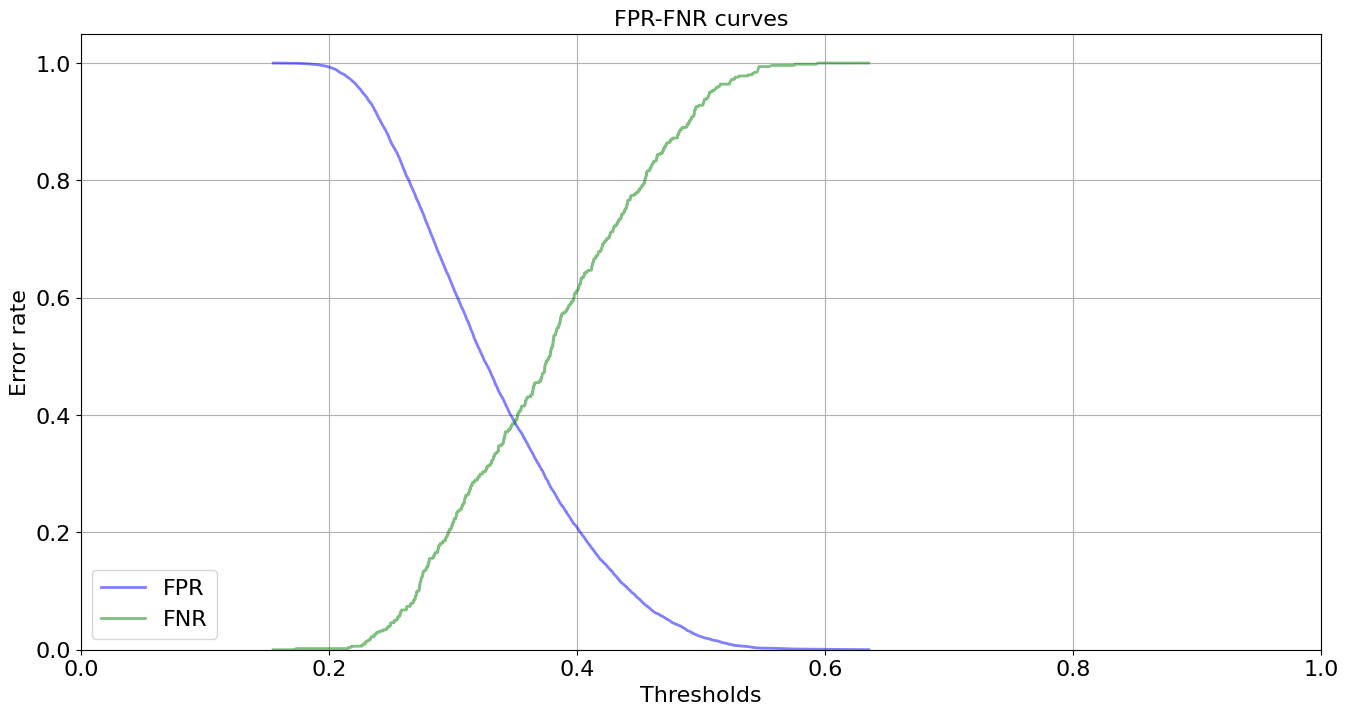

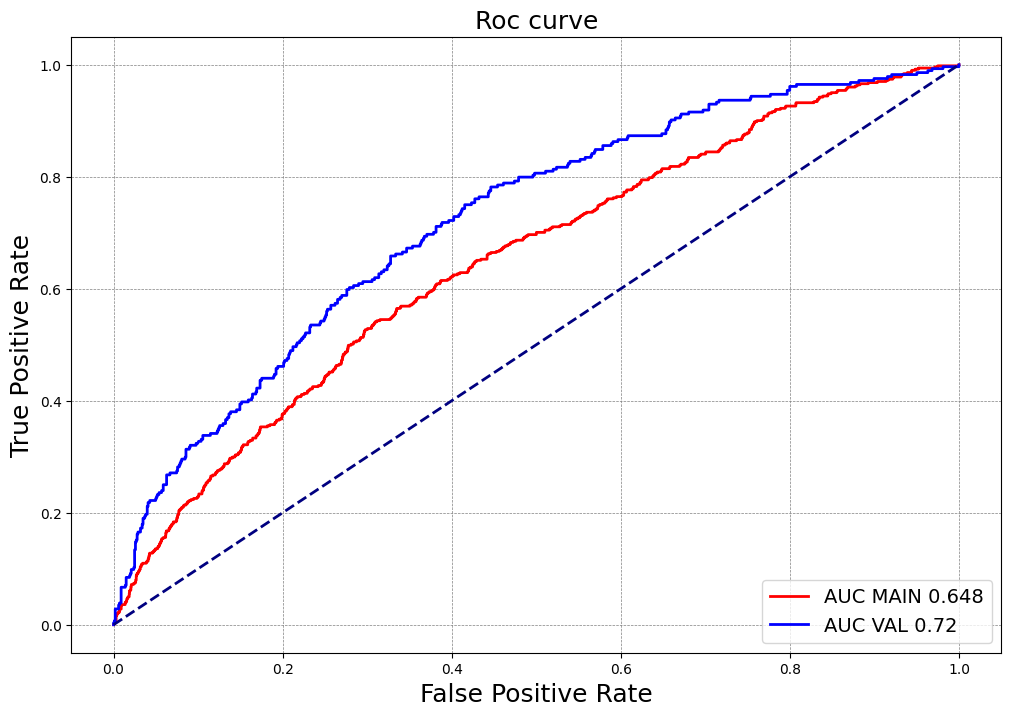

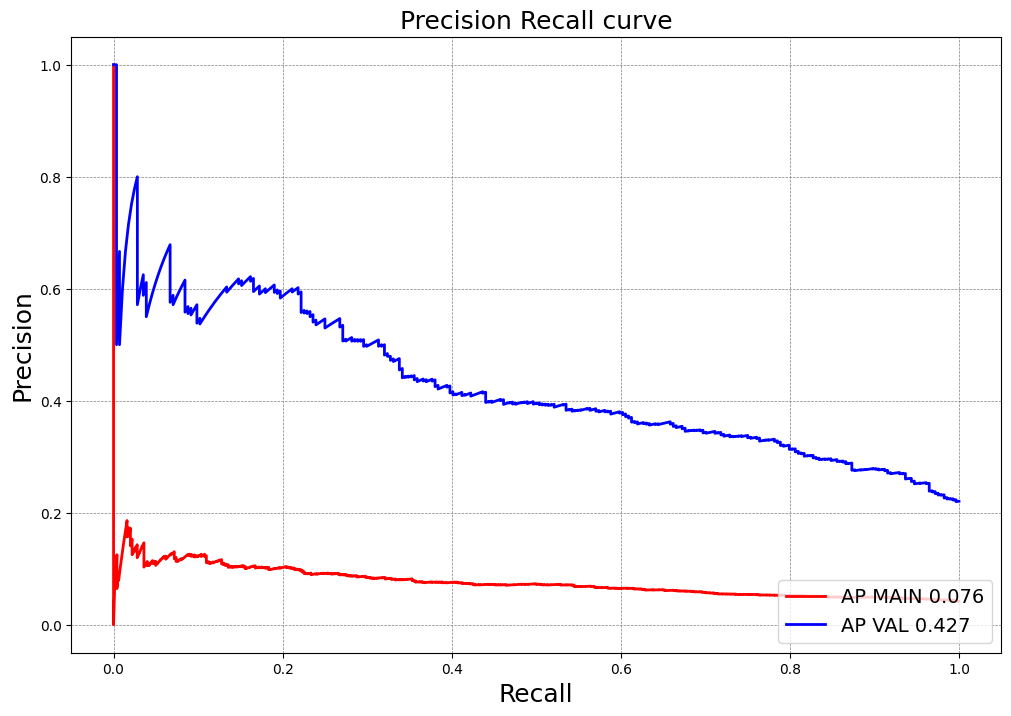

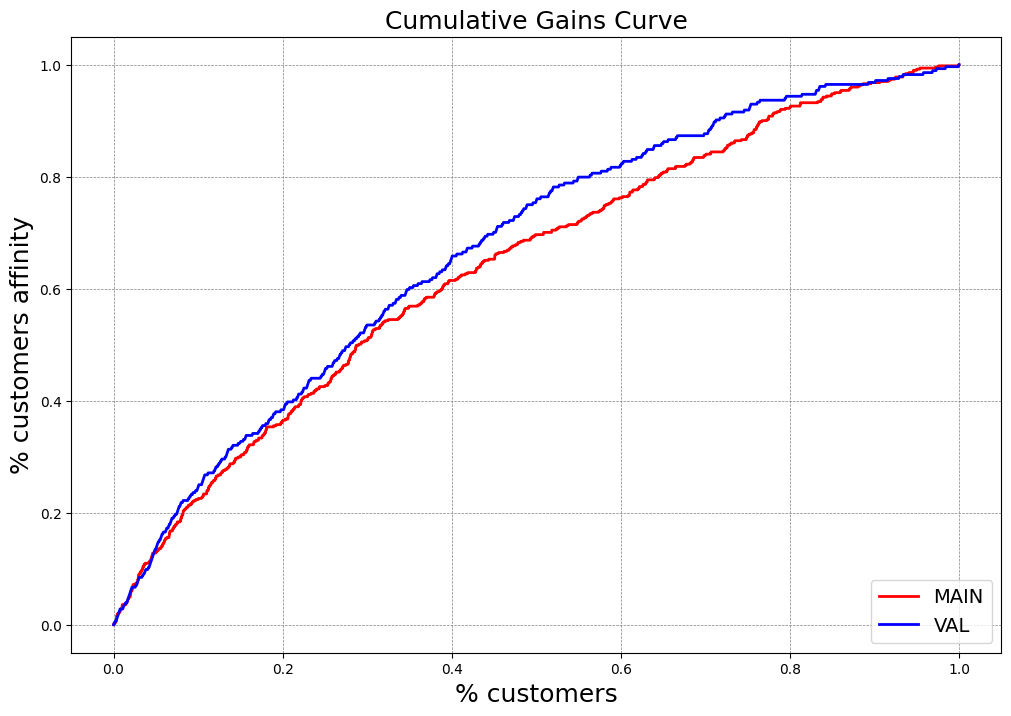

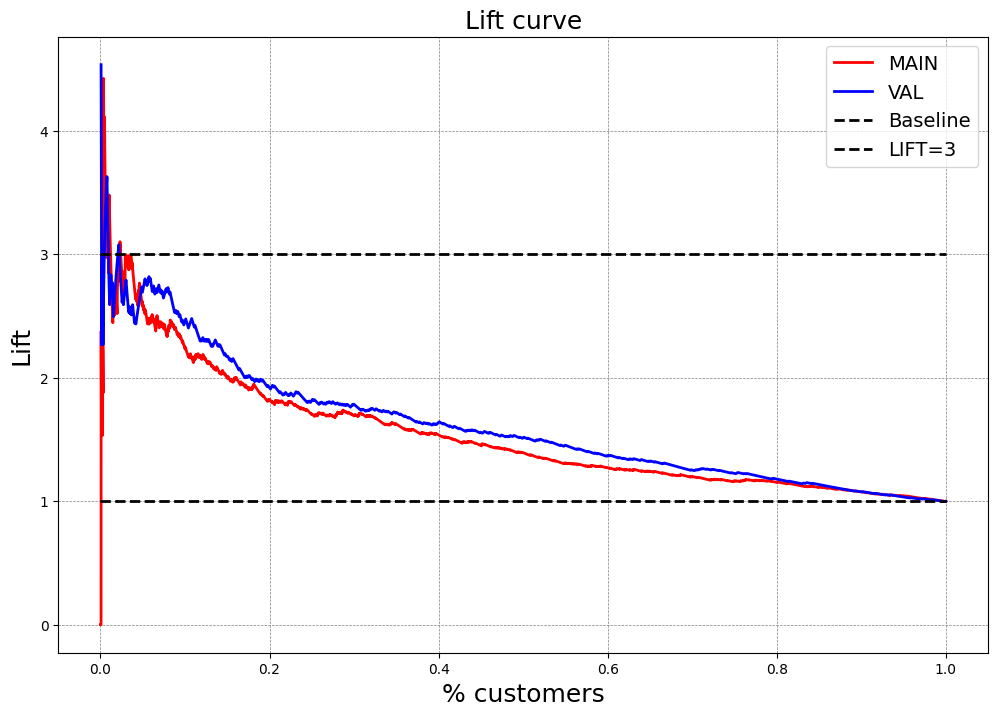

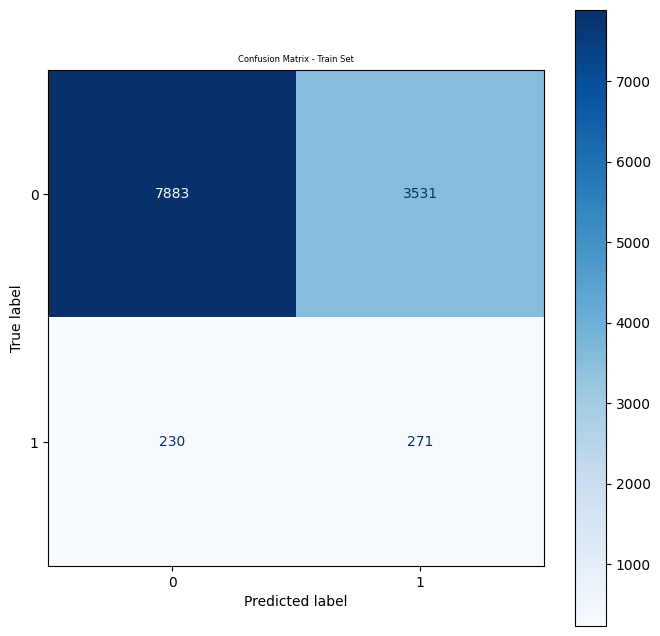

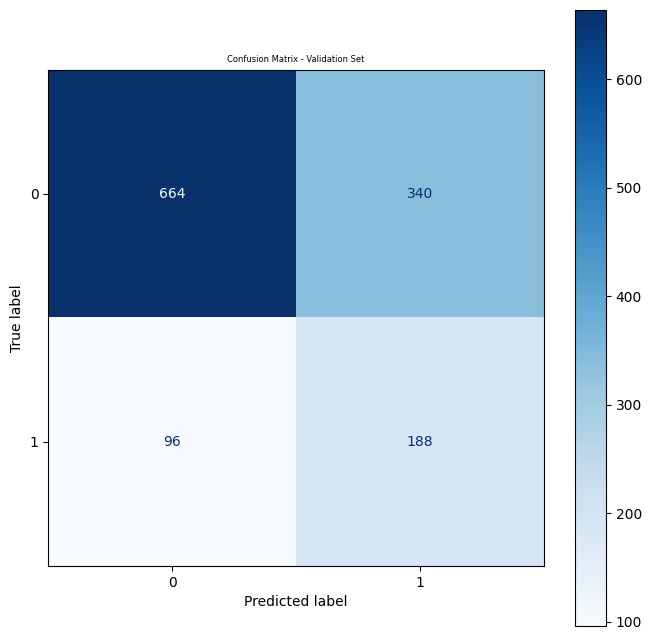

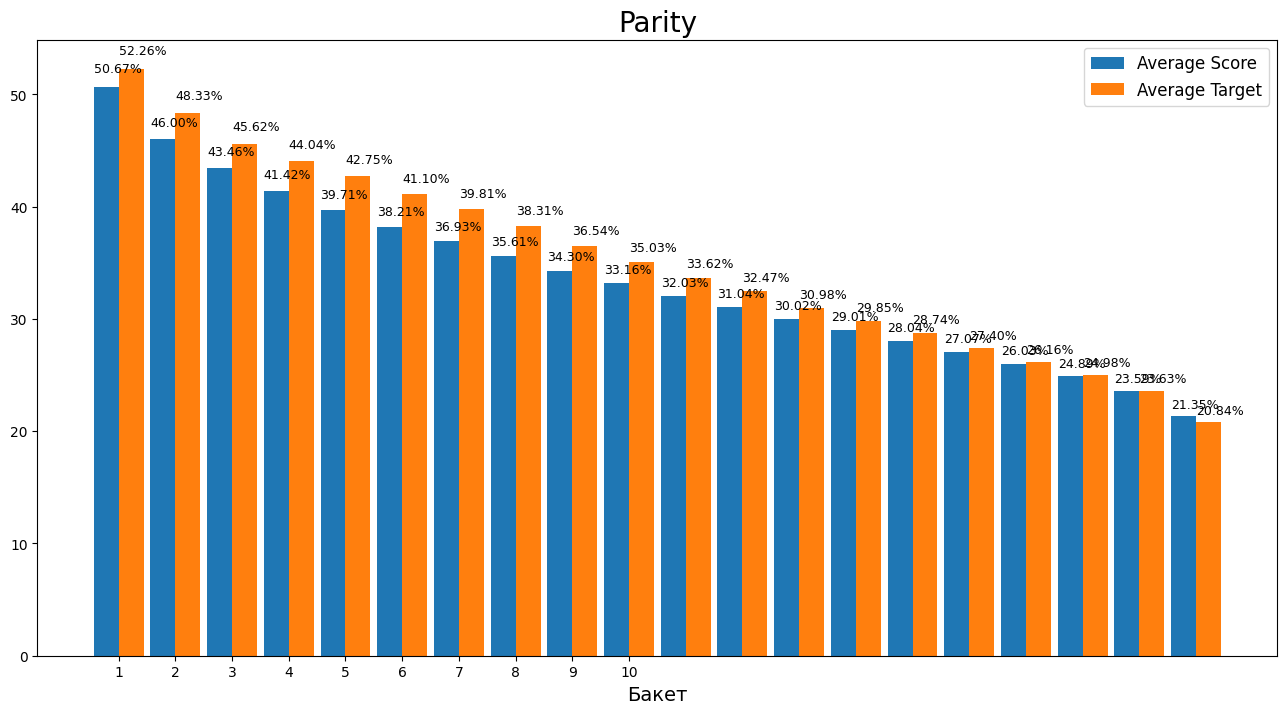

In [37]:
with mlflow.start_run(run_id=run_id):     
    optimal_threshold, optimal_f1_threshold, fpr_fnr_path = fpr_fnr(
        y_train_arr,   
        train_probs,                
        save_flg=True,
        plt_show=False,
        artifacts_dir=artifacts_dir
    )
    logger.info(f"Optimal threshold determined: {optimal_threshold}")
    mlflow.log_param("optimal_threshold", optimal_threshold)
    mlflow.log_param("optimal_f1_threshold", optimal_f1_threshold)
    mlflow.log_artifact(fpr_fnr_path)
    # vectors для plotting
    vectors = {
        "MAIN": [y_train_arr, train_probs],
        "VAL":  [y_val_arr,   val_probs]
    }

    # ROC/PR/Gain/Lift
    fig_roc, path_roc = plot_roc_curve(vectors, metric="auc", show_flg=False, save_flg=True, filename="roc_curve.png", artifacts_dir=artifacts_dir)
    mlflow.log_artifact(path_roc)
    fig_pr, path_pr = plot_precision_recall(vectors, show_flg=False, save_flg=True, filename="precision_recall_curve.png", artifacts_dir=artifacts_dir)
    mlflow.log_artifact(path_pr)
    fig_gain, path_gain = plot_cum_gain_curve(vectors, show_flg=False, save_flg=True, filename="cum_gain_curve.png", artifacts_dir=artifacts_dir)
    mlflow.log_artifact(path_gain)
    fig_lift, path_lift = plot_lift_curve(vectors, show_flg=False, save_flg=True, filename="lift.jpg", artifacts_dir=artifacts_dir)
    mlflow.log_artifact(path_lift)
    n_cols = len(numeric_cols) + len(categorical_cols)
    X_train_dummy = pd.DataFrame(np.zeros((len(y_train_arr), n_cols)), columns=[f"c{i}" for i in range(n_cols)])

    # Вызов get_save_metrics для LSTM
    results = get_save_metrics(
        X_train_dummy,
        y_train_arr,      # метки из датасета LSTM
        train_probs,      # вероятности из LSTM
        y_val_arr,        # oot метки
        val_probs,        # oot вероятности
        BETA,
        best_params={},   # при необходимости передайте dict гиперпараметров
        optimal_threshold=optimal_threshold,
        save_to_mlflow=True
    )
    mlflow.log_param("BETA", BETA)
   
    # Plot and log confusion matrix
    confusion_matrix_filename = "confusion_matrix_train.png"
    fig, path = plot_confusion_matrix( y_train_arr, train_probs, optimal_threshold, 
                                      save_flg=True, show_flg=False, 
                                      filename=confusion_matrix_filename, 
                                      artifacts_dir=artifacts_dir,
                                      title_text="Confusion Matrix - Train Set"
                                      )

    logger.info(f"Confusion matrix {confusion_matrix_filename} logged to MLflow.")
    mlflow.log_artifact(path)
    # Plot and log confusion matrix
    confusion_matrix_filename = "confusion_matrix_oot.png"
    fig, path = plot_confusion_matrix( y_val_arr, val_probs, optimal_threshold, 
                                      save_flg=True, show_flg=False, 
                                      filename=confusion_matrix_filename, 
                                      artifacts_dir=artifacts_dir,
                                      title_text="Confusion Matrix - Validation Set"
                                      )
    mlflow.log_artifact(path)       
    logger.info(f"Confusion matrix {confusion_matrix_filename} logged to MLflow.")
    fig_buckets, path_buckets = plot_buckets(
                preds_old=train_probs,
                preds_new=val_probs,
                kind="buckets",
                n_bins=20,
                label="Parity",
                scale="perc",
                label_old="Average Score",
                label_new="Average Target",
                show_flg=False,
                save_flg=True,
                artifacts_dir=artifacts_dir,
                filename='buckets.jpg'
            )
    mlflow.log_artifact(path_buckets)
    logger.info(f"Buckets plot logged to MLflow.")

In [38]:
results

,Number of columns,ROC AUC TRAIN,Precision TRAIN,Recall TRAIN,F1-Score TRAIN,Accuracy TRAIN,ROC AUC OOT,Precision OOT,Recall OOT,F1-Score OOT,Accuracy OOT,objective
0,39,0.647928,0.071278,0.540918,0.125959,0.684347,0.720111,0.356061,0.661972,0.463054,0.661491,0.669963


In [39]:
from src.visualization import calculate_lift_statistics
# Вычисление для ваших данных
lift_stats = calculate_lift_statistics(y_val_arr, val_probs)

# Логирование
with mlflow.start_run(run_id=run_id):
    for key, value in lift_stats.items():
        mlflow.log_metric(key, value)

print("Lift Statistics для VAL:")
for key, value in lift_stats.items():
    print(f"{key}: {value:.2f}")

🏃 View run nimble-hare-441 at: http://10.16.230.222:5000/#/experiments/3/runs/cc0502a42ac843fd91322e9f7f8ae636
🧪 View experiment at: http://10.16.230.222:5000/#/experiments/3
Lift Statistics для VAL:
lift_top_1: 3.02
lift_top_5: 2.69
lift_top_10: 2.44
lift_top_20: 1.92
lift_top_50: 1.51
